useful resource: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## these modules need to be installed before starting

In [56]:
pip install chart_studio 

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install scattertext

Note: you may need to restart the kernel to use updated packages.


In [58]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [98]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm
#nlp = spacy.load('en_core_web_md')
nlp = en_core_web_sm.load()

Loading BokehJS ...

In [60]:
#%cd "gdrive/My Drive/Colab Notebooks"
!ls

Convention-Visualization.html nlp_EDA_v2.ipynb
Extract_subtitles.ipynb       nlp_EDA_v3.ipynb
Extract_subtitles2.ipynb      nlp_EDA_v4.ipynb
nlp_EDA.ipynb                 nlp_model_training.ipynb


In [99]:
# load train_cleaned.csv
filename = "~/Documents/GitHub/esade_fake_news/1_Climate_Change/youtube_query/data/nlp/00000000-000000_climate_change_nlp_subs.csv"
df = pd.read_csv(filename, usecols=['Bias_num', 'subtitles','channel'])
df_channel = df.copy()
df['text'] = df['subtitles']
df.drop(['subtitles','channel'], axis=1, inplace=True)
df['text'] = df['text'].str[2:-2]
df.head()

,Bias_num,text
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,[Music] yeah Irish aqua five bucks North North...


In [100]:
#df['text'] = df['title'] + " " + df['description']
#df.drop(['title', 'description'], inplace=True, axis=1)

#drop NAs
df.dropna(inplace=True)

In [101]:
df['Bias_num'].mean()

0.19331742243436753

## Subtitles cleaning

In [102]:
#split channel string to remove each element from subtitles
df_channel['channel'] = df_channel['channel'].replace("(in English)", '', regex=True)
unique_channel = df_channel['channel'].unique()
unique_channel_split = [i.split(' ') for i in unique_channel]
unique_channel_split[0]

['ABC', 'News']

In [103]:
#remove all channels from text
for channel in unique_channel_split:
    for element in channel:
        df['text'].replace(element,
                           '',
                           inplace=True,
                           regex=True)

In [104]:
#values to be replaced
to_replace = ['Music', 'Applause', 'Laughter']

df['text'].replace(to_replace, '', inplace=True, regex=True)  

In [105]:
df['text'].replace('Music', "", inplace=True)

In [106]:
df['text'] = df['text'].apply(lambda x: x.replace('Music', ""))

In [107]:
#drop channel, not needed
#df.drop('channel', inplace=True, axis=1)

In [108]:
#calculate number of characters
df['review_len'] = df['text'].astype(str).apply(len)

#calculate number of words
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,Bias_num,text,review_len,word_count
4,0.0,[] yeah Irish aqua five bucks North North Kore...,21735,4086
5,0.0,you can't say it but you know it's true good e...,15235,2870
6,0.0,[] [] there is a certaty to life Roberts Coun...,28729,5433
7,0.0,honestly what they say doesn't bother me I und...,2589,491
12,0.0,do I believe UFOs or extraterrestrial visitor...,17047,3165


(array([209., 107.,  51.,  24.,  12.,   6.,   3.,   5.,   1.,   1.]),
 array([  1189. ,  15422.6,  29656.2,  43889.8,  58123.4,  72357. ,
         86590.6, 100824.2, 115057.8, 129291.4, 143525. ]),
 <a list of 10 Patch objects>)

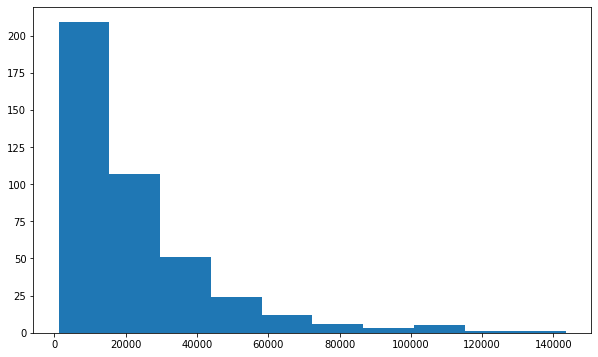

In [109]:
plt.hist(df['review_len'])

(array([212., 103.,  53.,  25.,  12.,   4.,   3.,   5.,   1.,   1.]),
 array([  206. ,  2735.8,  5265.6,  7795.4, 10325.2, 12855. , 15384.8,
        17914.6, 20444.4, 22974.2, 25504. ]),
 <a list of 10 Patch objects>)

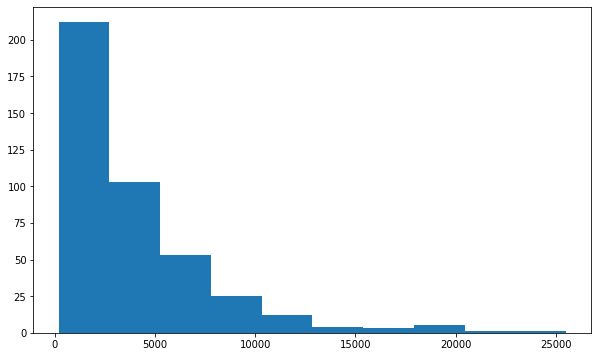

In [110]:
plt.hist(df['word_count'])

In [111]:
x1 = df.loc[df['Bias_num'] == 1, 'word_count']
x0 = df.loc[df['Bias_num'] == 0, 'word_count']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of word count based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [112]:
x1 = df.loc[df['Bias_num'] == 1, 'review_len']
x0 = df.loc[df['Bias_num'] == 0, 'review_len']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of review_len based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

## The distribution of top unigrams before removing stop words

In [113]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

,text,count
0,the,88641
1,to,52672
2,that,38743
3,you,33074
4,it,29376
5,is,25100
6,we,24153
7,this,16183
8,have,13568
9,they,13431


## The distribution of top unigrams after removing stop words

In [114]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2
df2.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

,text,count
0,people,7425
1,know,5972
2,just,5793
3,like,5646
4,thk,4575
5,don,4463
6,ve,4005
7,gog,3976
8,right,3754
9,time,3427


## The distribution of top bigrams before removing stop words

In [115]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3
df3.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')


,text,count
0,to the,4344
1,to be,3443
2,this is,3161
3,we re,3055
4,on the,3016
5,you know,2885
6,you re,2783
7,gog to,2748
8,if you,2707
9,that the,2465


## The distribution of top bigrams after removing stop words

In [116]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4
df4.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

,text,count
0,ve got,791
1,don know,743
2,united states,653
3,years ago,534
4,little bit,415
5,donald trump,379
6,don thk,376
7,don want,355
8,make sure,331
9,climate change,323


## The distribution of Top trigrams before removing stop words

In [117]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5
df5.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

,text,count
0,re gog to,614
1,the united states,592
2,gog to be,535
3,we have to,535
4,you have to,474
5,this is the,447
6,be able to,401
7,we need to,395
8,you want to,388
9,if you re,385


## The distribution of Top trigrams after removing stop words

In [118]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

,text,count
0,million years ago,74
1,want make sure,67
2,health care workers,51
3,new york city,44
4,president united states,43
5,uncommon knowledge peter,42
6,knowledge peter robson,41
7,000 years ago,40
8,welcome uncommon knowledge,37
9,president uni states,35


## Find top trigrams after removing stop words for RIGHT

In [136]:
#create df with only right subtitles
right = df[df['Bias_num']==1]
right.head(1)

#create df with only left subtitles
left = df[df['Bias_num']==0]
left.head(1)

,Bias_num,text,review_len,word_count
46,1.0,you are watchg places every Tuesday we brg you...,8910,1575


,Bias_num,text,review_len,word_count
4,0.0,[] yeah Irish aqua five bucks North North Kore...,21735,4086


In [137]:
#right wing trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(right['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', 
    title='Top 20 trigrams for RIGHT wing media in subtitles after removing stop words')

In [138]:
#LEFT wing trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(left['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', 
    title='Top 20 trigrams for LEFT wing media in subtitles after removing stop words')

## Finding characteristic terms and their associations

In [119]:
#convert Bias_num to string
df_corpus = df.copy()
df_corpus['Bias_num'] = df_corpus['Bias_num'].apply(str)
print(df_corpus.dtypes)

Bias_num      object
text          object
review_len     int64
word_count     int64
dtype: object


In [120]:
df_corpus.head()

,Bias_num,text,review_len,word_count
4,0.0,[] yeah Irish aqua five bucks North North Kore...,21735,4086
5,0.0,you can't say it but you know it's true good e...,15235,2870
6,0.0,[] [] there is a certaty to life Roberts Coun...,28729,5433
7,0.0,honestly what they say doesn't bother me I und...,2589,491
12,0.0,do I believe UFOs or extraterrestrial visitor...,17047,3165


In [121]:
#Following are the terms that differentiate the review text from a general English corpus.
corpus = st.CorpusFromPandas(df_corpus, category_col='Bias_num', text_col='text', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['thk', 'gog', 'thgs', 'somethg', 'thg', 'sayg', 'tryg', 'gon', 'gettg', 'aga']


In [122]:
#Following are the terms in review text that are most associated with right wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Right score'] = corpus.get_scaled_f_scores("1.0")
pprint(list(term_freq_df.sort_values(by='Right score', ascending=False).index[:20]))

['stal',
 'close quote',
 'quote',
 'temperature',
 'warmg',
 't',
 'global warmg',
 'reagan',
 'peter',
 'co2',
 'argument',
 'telligence',
 'soviet',
 'blacks',
 'so forth',
 'all right',
 'black',
 'the book',
 'book',
 'theory']


In [123]:
#Following are the terms in review text that are most associated with left wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Left score'] = corpus.get_scaled_f_scores("0.0")
pprint(list(term_freq_df.sort_values(by='Left score', ascending=False).index[:20]))

['clinton',
 "you\\'re",
 "we\\'re",
 "i\\'ve",
 "i\\'m",
 "i don\\'t",
 "they\\'re",
 "don\\'t",
 'reporter',
 '\\',
 'and i',
 'it\\',
 "\\ 's",
 "it\\ 's",
 'n’t',
 "can\\'t",
 'there\\',
 "there\\ 's",
 "that\\ 's",
 'what\\']


In [124]:
html = st.produce_scattertext_explorer(corpus,
                                       category='0.0',
                                       category_name='Left',
                                       not_category_name='Right',
                                       width_in_pixels=1000)

open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

14109687

In [125]:
reindexed_data = df['text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [126]:
n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [127]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [128]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [129]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [130]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  people like know
Topic 2:  trump going think
Topic 3:  climate carbon co2
Topic 4:  reporter going think
Topic 5:  airles virus cruise


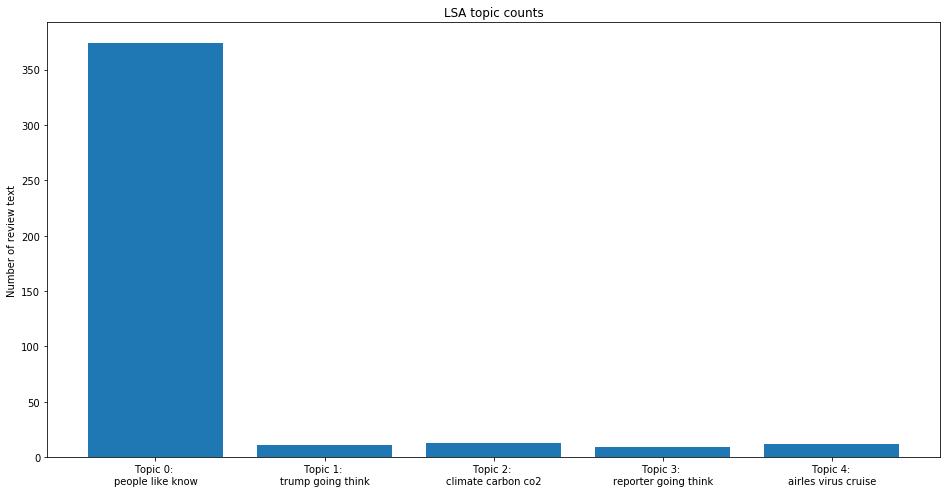

In [131]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [132]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 419 samples in 0.002s...
[t-SNE] Computed neighbors for 419 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 419 / 419
[t-SNE] Mean sigma: 0.078326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.153503
[t-SNE] KL divergence after 900 iterations: 0.409179


In [133]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [134]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [135]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

GlyphRenderer(id='1253', ...)